In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

from PIL import Image 

import scanpy
import anndata as ad

import networkx as nx
import scipy.stats

In [2]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)

nmco_all=None
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,'nmco_allfeatures'), 'rb') as output:
                nmco=pickle.load(output)[:,1:] #excluding label column

            if nmco_all is None:
                nmco_all=nmco
            else:
                nmco_all=np.concatenate((nmco_all,nmco),axis=0)


controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
P15


In [3]:
nmco_all.shape

(32748, 234)

In [4]:
nmco_all_finite=np.copy(nmco_all)
nmco_all_finite[np.logical_not(np.isfinite(nmco_all))]=0
nmco_all_finite=nmco_all_finite[:,np.sum(np.isfinite(nmco_all),axis=0)>0]

In [5]:
#exclude centroid positions
centroidColIdx=np.array([12,13,89,90])
keepIdx=np.repeat(True,nmco_all_finite.shape[1])
keepIdx[centroidColIdx]=False
nmco_all_finite=nmco_all_finite[:,keepIdx]


In [6]:
with open(os.path.join(sourceDir,'nmco_allfeatures_names'), 'rb') as output:
    nmco_names=pickle.load(output)[1:]
nmco_names_finite=nmco_names[np.sum(np.isfinite(nmco_all),axis=0)>0]
nmco_names_finite=nmco_names_finite[keepIdx]

In [7]:
with open(os.path.join(sourceDir,'nmco_allfeatures_names_finite'), 'wb') as output:
    pickle.dump(nmco_names_finite,output,pickle.HIGHEST_PROTOCOL)

In [8]:
nmco_all_finite=scipy.stats.zscore(nmco_all_finite,axis=0,nan_policy='omit')

In [9]:
df = pd.DataFrame(nmco_all_finite,columns=nmco_names_finite)
corr = df.corr()
mask_keep = np.triu(np.ones(corr.shape), k=1).astype('bool').reshape(corr.size)
sr = corr.stack(dropna=False)[mask_keep]
# filter and get names
edges = sr[sr > 0.7].reset_index().values[:, :2]
g = nx.from_edgelist(edges)
ls_cc_order = []
for cc in nx.connected_components(g):
    ls_cc_order.extend(list(cc))
print(len(ls_cc_order))
for n in nmco_names_finite:
    if n not in ls_cc_order:
        ls_cc_order.append(n)

200


In [10]:
ls_cc = []
for cc in nx.connected_components(g):
    ls_cc.append(list(cc))


In [11]:
len(ls_cc)

18

In [12]:
ls_cc

[['std_curvature',
  'weighted_moments-2-3',
  'weighted_moments_central-1-3',
  'moments-1-1',
  'med_neg_curv',
  'homogeneity_25',
  'moments_hu-2',
  'prominant_pos_curv',
  'moments_hu-4',
  'weighted_moments-0-1',
  'weighted_moments_normalized-3-1',
  'weighted_moments-2-0',
  'bbox_area',
  'mode_radius',
  'shape_factor',
  'solidity',
  'moments-0-3',
  'std_posi_curv',
  'moments_hu-0',
  'energy_25',
  'moments_normalized-1-3',
  'frac_peri_w_neg_curvature',
  'weighted_moments-2-1',
  'weighted_moments-0-2',
  'moments_hu-3',
  'moments-1-2',
  'max_calliper',
  'std_neg_curv',
  'convex_hull_vol',
  'homogeneity_5',
  'weighted_moments_central-0-0',
  'len_neg_curv',
  'weighted_moments_hu-2',
  'weighted_moments_normalized-1-3',
  'moments-1-0',
  'min_calliper',
  'area_bbarea',
  'weighted_moments_normalized-3-3',
  'weighted_moments-2-2',
  'equivalent_diameter',
  'moments-3-2',
  'moments-0-1',
  'weighted_moments_hu-1',
  'weighted_moments_hu-4',
  'moments-2-2',
 

In [13]:

ls_cc_mostConnected=[]
for ccidx in range(len(ls_cc)):
    maxDegree=0
    maxEle=None
    for ccEle in ls_cc[ccidx]:
        if g.degree()[ccEle]>maxDegree:
            maxDegree=g.degree()[ccEle]
            maxEle=ccEle
    print('cc: '+str(ccidx))
    print(len(ls_cc[ccidx]))
    print(maxDegree)
    ls_cc_mostConnected.append(maxEle)

cc: 0
130
54
cc: 1
2
1
cc: 2
19
18
cc: 3
5
4
cc: 4
2
1
cc: 5
3
2
cc: 6
4
3
cc: 7
4
3
cc: 8
5
4
cc: 9
4
2
cc: 10
2
1
cc: 11
2
1
cc: 12
2
1
cc: 13
2
1
cc: 14
2
1
cc: 15
8
7
cc: 16
2
1
cc: 17
2
1


In [57]:
ls_cc_mostConnected

['bbox_area',
 'a_r',
 'nuclear_mean_int',
 'hc_content_ec_content',
 'dissimilarity_100',
 'homogeneity_100',
 'moments_normalized-0-3',
 'moments_normalized-1-2',
 'moments_normalized-2-1',
 'moments_central-3-0',
 'moments_central-2-3',
 'moments_central-3-2',
 'weighted_moments_hu-6',
 'extent',
 'rel_hc_volume',
 'rdp_2',
 'q25_dna_3d_int',
 'skewness_dna_3d_int']

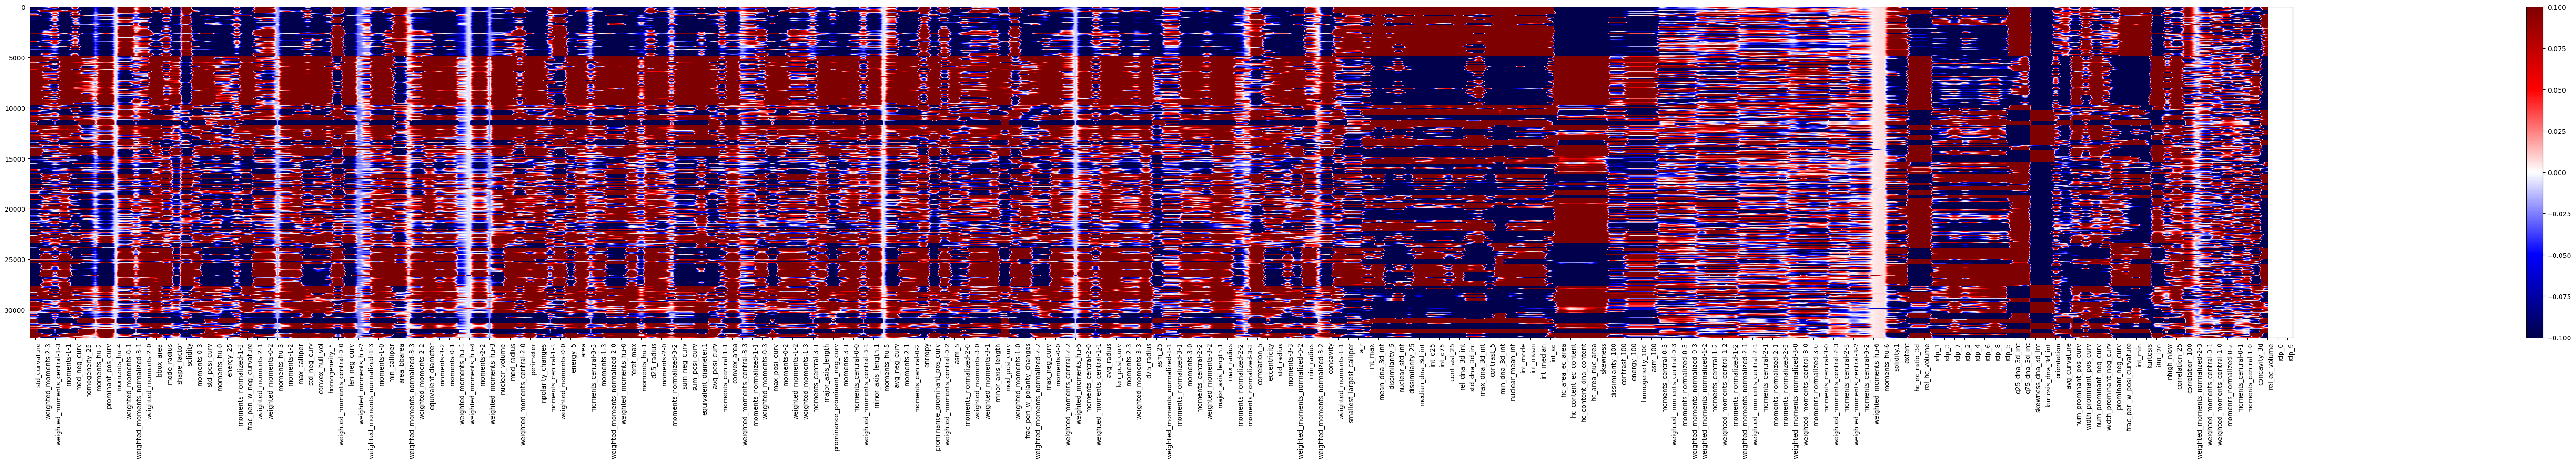

In [20]:
df_plot=df.copy()[ls_cc_order]

fig, ax = plt.subplots(figsize=(100, 10))
im = ax.imshow(df_plot.to_numpy(),cmap='seismic',vmin=-np.max(np.abs(nmco_all_finite)),vmax=np.max(np.abs(nmco_all_finite)),aspect=0.001)
ax.set_xticks(np.arange(nmco_names_finite.size))
ax.set_xticklabels(ls_cc_order)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
#     fig.set_figheight(35)
#     fig.set_figwidth(35)
fig.colorbar(im)
fig.tight_layout()
# plt.savefig(os.path.join(nmcodesavepath,'nmco_groups.jpg'))
plt.show()

In [63]:
df_plot

,weighted_moments_central-2-2,moments-3-3,weighted_moments_normalized-2-0,major_axis_length,moments-3-2,moments_central-2-2,weighted_moments_normalized-0-2,weighted_moments-3-2,homogeneity_5,equivalent_diameter.1,...,weighted_moments_normalized-2-3,weighted_moments_central-0-1,weighted_moments_central-1-0,moments_normalized-0-2,moments_central-0-1,moments_central-1-0,concavity_3d,rel_ec_volume,rdp_0,rdp_9
0,2.160290e+10,1.318484e+13,0.000362,73.594811,2.560444e+11,1.367841e+08,0.000608,4.210194e+13,0.194039,37.472521,...,1.009349e-10,-1.633329e-09,6.621121e-10,0.104554,-5.558576e-11,-1.962519e-11,0.138897,0.927698,0.0,1.0
1,2.922374e+10,1.406291e+13,0.000731,78.302422,3.499203e+11,2.213775e+08,0.000442,4.769304e+13,0.163994,38.222259,...,1.877095e-10,-3.659761e-10,-1.561602e-09,0.063235,-8.327561e-12,5.326228e-11,0.124086,0.929886,0.0,1.0
2,3.349937e+10,2.217078e+13,0.000599,79.423115,4.546208e+11,2.290664e+08,0.000515,6.954153e+13,0.230923,37.737676,...,-1.736051e-10,-2.547986e-09,-4.638423e-10,0.081558,1.571010e-11,-1.188027e-11,0.129062,0.927612,0.0,1.0
3,1.843350e+10,1.248669e+13,0.000525,66.380079,2.832213e+11,1.333788e+08,0.000470,4.069507e+13,0.197976,36.341091,...,8.135139e-10,-6.543088e-10,-1.493845e-09,0.075633,1.378453e-12,-1.857359e-11,0.157983,0.931596,0.0,1.0
4,1.697556e+10,7.316100e+12,0.000455,64.286988,1.710385e+11,1.114120e+08,0.000515,2.770662e+13,0.173952,36.501862,...,-2.487041e-10,-1.784560e-10,-8.003553e-11,0.085336,6.480150e-12,-2.106404e-11,0.114692,0.936972,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32743,1.828663e+10,1.352283e+13,0.000556,74.600896,2.729812e+11,1.742584e+08,0.000812,3.149415e+13,0.195961,38.032635,...,-2.721294e-09,-4.233714e-10,3.276313e-10,0.099391,1.534772e-12,2.228973e-11,0.130415,0.919042,0.0,1.0
32744,8.367406e+09,3.809853e+12,0.000505,68.672772,8.551397e+10,8.682536e+07,0.001008,8.617787e+12,0.172289,37.604441,...,-2.576922e-09,-3.833520e-10,4.474714e-10,0.115618,-1.207923e-12,-8.284928e-12,0.169857,0.921596,0.0,1.0
32745,2.652390e+10,2.548722e+13,0.000865,81.681588,5.635580e+11,2.317534e+08,0.000550,6.739956e+13,0.290242,34.384693,...,-7.787844e-10,-1.050975e-09,1.232820e-09,0.068937,6.366463e-12,3.461054e-11,0.322339,0.936155,0.0,1.0
32746,1.375590e+10,1.643987e+13,0.000839,69.599041,3.350115e+11,1.656874e+08,0.000938,2.984875e+13,0.224920,41.353708,...,-6.835706e-11,-1.357647e-10,-4.246772e-10,0.085717,1.817568e-11,1.331912e-11,0.148876,0.920684,0.0,1.0
